In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from misc import reportProgress
from scipy.ndimage.filters import gaussian_filter
from misc import round_sig_str as round_sig_str
import misc
import MarksConstants as mc
from importlib import reload
import cameraSimulation as cs
import imageBlurring as ib

In [24]:
#avgPhotonsPerImage = 50
QE = 0.9
seed = random.randint(1,70)
rs = np.random.RandomState(seed)
size = 128
#center of array
p0=int(size/2)
h_pixelsInBin = 2
v_pixelsInBin = 2
zTotalSize = 5e-6
timeStep = 10
time = 2*timeStep
numZPoints = 50

In [25]:
sensorArray = np.zeros((size,size))
print(sensorArray.shape)

(128, 128)


Text(0.5, 1.0, 'EM Gain Sampling Distribution')

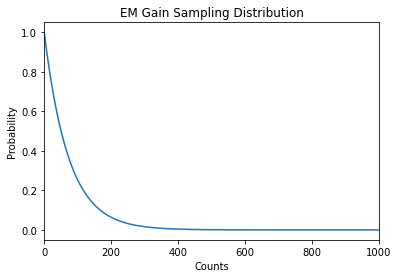

In [26]:
x = np.arange(3000)
def gain(x): 
    return np.exp(-0.0137615*x)

def readOutNoise(x):
    return np.exp(-(x-88.4)**2/52.84)

gain_pdf=gain(x)
readout_pdf = readOutNoise(x)

plt.plot(x, gain(x))
plt.xlim(0,1000)
plt.xlabel('Counts')
plt.ylabel('Probability')
plt.title('EM Gain Sampling Distribution')

In [27]:
CICNoise = 0.0699
darkElectronChance = 0.0003

def backgroundNoise(sensorArray):
    NoisyBlurryImage = np.zeros((size,size))
     #This loop applies Poisson-distributed shotnoise.        
    for rowi, row in enumerate(NoisyBlurryImage):
        for coli, col in enumerate(row):
            #sample from blurred wave function
            #value at blurred image is mean intensity, value returned by rs.poisson is shotnoise
            NoisyBlurryImage[rowi, coli] += rs.poisson(sensorArray[rowi, coli])
            
    for rowi, row in enumerate(NoisyBlurryImage):
            for coli, col in enumerate(row):
                numPhotons = NoisyBlurryImage[rowi, coli]
                numElectrons = numPhotons*QE

            #chance to find a dark electron/dark current         
                if np.random.random() < darkElectronChance:
                    numElectrons += 1    

                NoisyBlurryImage[rowi, coli] += numElectrons

            #chance of CIC
                if np.random.random() < CICNoise:
                    numElectrons += 1

                NoisyBlurryImage[rowi, coli] += numElectrons   


            #EM gain amplification: using 1 distribution, sampling from it as many times as there are electrons on a pixel.
                if numElectrons == 0:
                    electronsGained = 0
                elif numElectrons == 1:
                    ElectronsOut = np.random.choice(x, p=gain_pdf/sum(gain_pdf))
                    electronsGained = ElectronsOut
                else:
                    ElectronsOut = np.random.choice(x, size=int(numElectrons), p=gain_pdf/sum(gain_pdf))
                    electronsGained = sum(ElectronsOut)

                NoisyBlurryImage[rowi, coli] += electronsGained

            #readout noise
                ElectronsOut = np.random.choice(x, p=readout_pdf/sum(readout_pdf))
                electronsRead = ElectronsOut

                NoisyBlurryImage[rowi, coli] += electronsRead
                
    return NoisyBlurryImage

(128, 128)


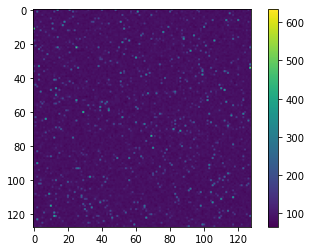

In [28]:
img = backgroundNoise(sensorArray)
print(img.shape)
plt.imshow(img)
plt.colorbar()

In [29]:
counts = []
for rowi, row in enumerate(img):
        for coli, col in enumerate(row):
            if img[rowi,coli] > 0:
                counts.append(int(img[rowi,coli]))
totalCount = sum(counts)
avgCount = sum(counts)/len(counts)
print(avgCount)
print(totalCount)
print(len(counts))

93.28466796875
1528376
16384


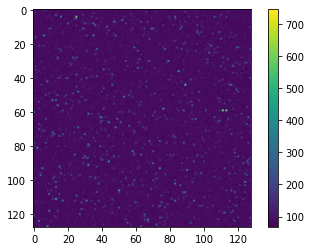

In [30]:
imageSeries = []

for imageNum in range(1000):
    imageSeries.append(backgroundNoise(sensorArray))
    np.save('noisesimnegligiblecic.npy', imageSeries)
    reportProgress(imageNum, 1000)
    
plt.imshow(imageSeries[5])
plt.colorbar()

<ipython-input-31-bcdd03418a6e>:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  heights, bins = np.histogram(fdata, np.arange(min(fdata)-1,max(fdata),1), normed=True)


Text(0.5, 1.0, 'Background Noise')

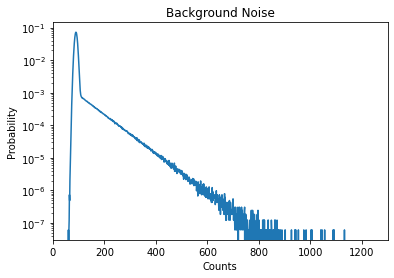

In [31]:
noiseIms = np.load('noisesimnegligiblecic.npy')
fdata = noiseIms.flatten()
heights, bins = np.histogram(fdata, np.arange(min(fdata)-1,max(fdata),1), normed=True)
plt.semilogy(bins[1:],heights)
plt.xlabel('Counts')
plt.ylabel('Probability')
plt.title('Background Noise')